In [ ]:
include("../dependencies.jl")
include("../functions/brute_force_new.jl")
include("../functions/boundary_evolution.jl")
include("../randompeps.jl")
push!(LOAD_PATH, "../functions/")
using BP, Ising2D
using Statistics, Plots

In [2]:
L = 10 
h = 0.

0.0

In [3]:
w_list = [4,6,8,10]

# Load loop data for all weights
loop_data = Dict()
for w in w_list
    data = load_latest_cluster_file(L,w)
    loop_objects = data.all_loops
    loop_data[w] = [loop_object.edges for loop_object in loop_objects]
    println("Loaded $(length(loop_data[w])) loops for weight $w")
end


📖 Loading cluster data from: open_clusters_L10_w4_2025-08-16T09-21-59-039.jld2
Loaded 100 loops for weight 4
Loaded 100 loops for weight 4
📖 Loading cluster data from: open_clusters_L10_w6_2025-08-16T09-22-33-513.jld2
Loaded 300 loops for weight 6
📖 Loading cluster data from: open_clusters_L10_w8_2025-08-16T09-22-55-957.jld2
Loaded 1400 loops for weight 8
📖 Loading cluster data from: open_clusters_L10_w10_2025-08-16T09-25-44-546.jld2
Loaded 10200 loops for weight 10
📖 Loading cluster data from: open_clusters_L10_w6_2025-08-16T09-22-33-513.jld2
Loaded 300 loops for weight 6
📖 Loading cluster data from: open_clusters_L10_w8_2025-08-16T09-22-55-957.jld2
Loaded 1400 loops for weight 8
📖 Loading cluster data from: open_clusters_L10_w10_2025-08-16T09-25-44-546.jld2
Loaded 10200 loops for weight 10


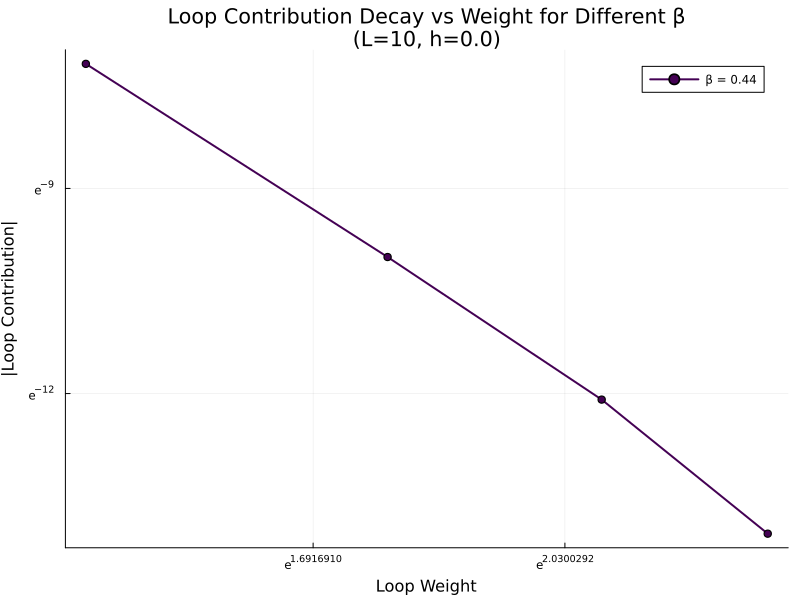

Processing β = 0.44


In [26]:
β_arr = [0.44]

# Use only the highest weight data which contains all loops up to that weight
all_loops = loop_data[w_list[end]]  # This contains loops of all weights up to 10

# Storage for results across different β values
results_by_beta = Dict()

for β in β_arr
    println("Processing β = $β")
    
    # Get Ising tensor network for this β
    tensors = Ising2D.get_ising_tn(L, β; h=h)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors, edges, links;random_part=0.1) 
    messages = BP.message_passing(tensors, messages, edges, adj_mat; α=1.0, max_iters=500, diagnose=false, normalise=true)
    Z_list = BP.get_fixed_point_list(tensors, messages, adj_mat)
    tensors = BP.normalize_tensors(tensors, Z_list)
    
    # Calculate loop contributions and organize by actual loop weight (length)
    loop_contributions_by_weight = Dict{Int, Vector{Float64}}()

    for loop in all_loops
        if all([e in edges for e in loop])
            loop_weight = length(loop)  # Actual weight is the loop length
            loop_contri = scalar(BP.loop_contribution(loop, messages, tensors, edges, links, adj_mat))
            
            if !haskey(loop_contributions_by_weight, loop_weight)
                loop_contributions_by_weight[loop_weight] = Float64[]
            end
            
            push!(loop_contributions_by_weight[loop_weight], abs(loop_contri))  # Take absolute value
        end
    end
    
    # Store results for this β
    results_by_beta[β] = loop_contributions_by_weight
end

# Create plot with all β values
even_weights = w_list
colors = palette(:viridis, length(β_arr))

p = plot(xlabel="Loop Weight", 
         ylabel="|Loop Contribution|",
         title="Loop Contribution Decay vs Weight for Different β\n(L=$L, h=$h)",
         grid=true,
         legend=:topright,
         size=(800, 600))

for (i, β) in enumerate(β_arr)
    avg_contribs = [mean(results_by_beta[β][w]) + 1e-50 for w in even_weights]
    
    # Normalize by the first weight contribution
    first_weight_contrib = avg_contribs[1]
    normalized_contribs = avg_contribs #./ first_weight_contrib
    
    plot!(p, even_weights, normalized_contribs,
          linewidth=2,
          markershape=:circle,
          yscale=:ln,
          xscale=:ln,
          markersize=4,
          label="β = $β",
          color=colors[i])
end
display(p)

Processing β = 0.8
Processing β = 0.7
Processing β = 0.7
Processing β = 0.6
Processing β = 0.6
Processing β = 0.5
Processing β = 0.4
Processing β = 0.5
Processing β = 0.4


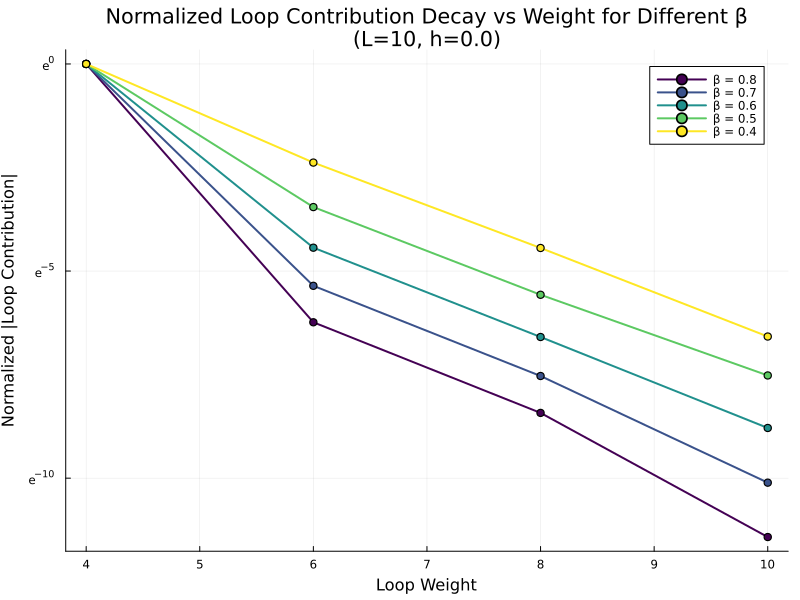

In [14]:
β_arr = reverse(collect(0.4:0.1:0.8))

# Use only the highest weight data which contains all loops up to that weight
all_loops = loop_data[w_list[end]]  # This contains loops of all weights up to 10

# Storage for results across different β values
results_by_beta = Dict()

for β in β_arr
    println("Processing β = $β")
    
    # Get Ising tensor network for this β
    tensors = Ising2D.get_ising_tn(L, β; h=h)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors, edges, links;random_part=0.1) 
    messages = BP.message_passing(tensors, messages, edges, adj_mat; α=1.0, max_iters=500, diagnose=false, normalise=true)
    Z_list = BP.get_fixed_point_list(tensors, messages, adj_mat)
    tensors = BP.normalize_tensors(tensors, Z_list)
    
    # Calculate loop contributions and organize by actual loop weight (length)
    loop_contributions_by_weight = Dict{Int, Vector{Float64}}()

    for loop in all_loops
        if all([e in edges for e in loop])
            loop_weight = length(loop)  # Actual weight is the loop length
            loop_contri = scalar(BP.loop_contribution(loop, messages, tensors, edges, links, adj_mat))
            
            if !haskey(loop_contributions_by_weight, loop_weight)
                loop_contributions_by_weight[loop_weight] = Float64[]
            end
            
            push!(loop_contributions_by_weight[loop_weight], abs(loop_contri))  # Take absolute value
        end
    end
    
    # Store results for this β
    results_by_beta[β] = loop_contributions_by_weight
end

# Create plot with all β values
even_weights = w_list
colors = palette(:viridis, length(β_arr))

p = plot(xlabel="Loop Weight", 
         ylabel="Normalized |Loop Contribution|",
         title="Normalized Loop Contribution Decay vs Weight for Different β\n(L=$L, h=$h)",
         grid=true,
         legend=:topright,
         size=(800, 600))

for (i, β) in enumerate(β_arr)
    avg_contribs = [mean(results_by_beta[β][w]) + 1e-50 for w in even_weights]
    
    # Normalize by the first weight contribution
    first_weight_contrib = avg_contribs[1]
    normalized_contribs = avg_contribs ./ first_weight_contrib
    
    plot!(p, even_weights, normalized_contribs,
          linewidth=2,
          markershape=:circle,
          yscale=:ln,
          markersize=4,
          label="β = $β",
          color=colors[i])
end
display(p)

Processing β = 0.4
Processing β = 0.5
Processing β = 0.6
Processing β = 0.6
Processing β = 0.7
Processing β = 0.8
Processing β = 0.7
Processing β = 0.8


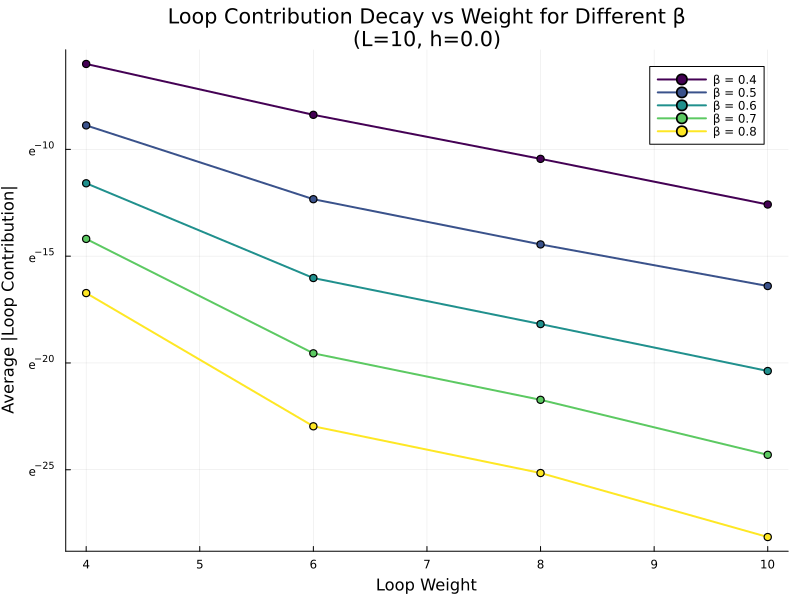

In [ ]:
β_arr = 0.4:0.1:0.8

# Use only the highest weight data which contains all loops up to that weight
all_loops = loop_data[w_list[end]]  # This contains loops of all weights up to 10

# Storage for results across different β values
results_by_beta = Dict()

for β in β_arr
    println("Processing β = $β")
    
    # Get Ising tensor network for this β
    tensors = Ising2D.get_ising_tn(L, β; h=h)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors, edges, links;random_part=0.1) 
    messages = BP.message_passing(tensors, messages, edges, adj_mat; α=1.0, max_iters=500, diagnose=false, normalise=true)
    Z_list = BP.get_fixed_point_list(tensors, messages, adj_mat)
    tensors = BP.normalize_tensors(tensors, Z_list)
    
    # Calculate loop contributions and organize by actual loop weight (length)
    loop_contributions_by_weight = Dict{Int, Vector{Float64}}()

    for loop in all_loops
        if all([e in edges for e in loop])
            loop_weight = length(loop)  # Actual weight is the loop length
            loop_contri = scalar(BP.loop_contribution(loop, messages, tensors, edges, links, adj_mat))
            
            if !haskey(loop_contributions_by_weight, loop_weight)
                loop_contributions_by_weight[loop_weight] = Float64[]
            end
            
            push!(loop_contributions_by_weight[loop_weight], abs(loop_contri))  # Take absolute value
        end
    end
    
    # Store results for this β
    results_by_beta[β] = loop_contributions_by_weight
end

# Create plot with all β values
even_weights = w_list
colors = palette(:viridis, length(β_arr))

p = plot(xlabel="Loop Weight", 
         ylabel="Normalized |Loop Contribution|",
         title="Normalized Loop Contribution Decay vs Weight for Different β\n(L=$L, h=$h)",
         grid=true,
         legend=:topright,
         size=(800, 600))

for (i, β) in enumerate(β_arr)
    avg_contribs = [mean(results_by_beta[β][w]) + 1e-50 for w in even_weights]
    
    # Normalize by the first weight contribution
    first_weight_contrib = avg_contribs[1]
    normalized_contribs = avg_contribs ./ first_weight_contrib
    
    plot!(p, even_weights, normalized_contribs,
          linewidth=2,
          markershape=:circle,
          yscale=:ln,
          markersize=4,
          label="β = $β",
          color=colors[i])
end
display(p)

Processing η = 0.5
  Sample 20/100
  Sample 40/100
  Sample 40/100
  Sample 60/100
  Sample 60/100
  Sample 80/100
  Sample 80/100
  Sample 100/100
  Sample 100/100
Processing η = 1.0
Processing η = 1.0
  Sample 20/100
  Sample 20/100
  Sample 40/100
  Sample 40/100
  Sample 60/100
  Sample 60/100
  Sample 80/100
  Sample 80/100
  Sample 100/100
  Sample 100/100
Processing η = 1.5
Processing η = 1.5
  Sample 20/100
  Sample 20/100
  Sample 40/100
  Sample 40/100
  Sample 60/100
  Sample 60/100
  Sample 80/100
  Sample 100/100
Processing η = 2.0
  Sample 20/100
  Sample 40/100
  Sample 60/100
  Sample 80/100
  Sample 100/100
  Sample 80/100
  Sample 100/100
Processing η = 2.0
  Sample 20/100
  Sample 40/100
  Sample 60/100
  Sample 80/100
  Sample 100/100


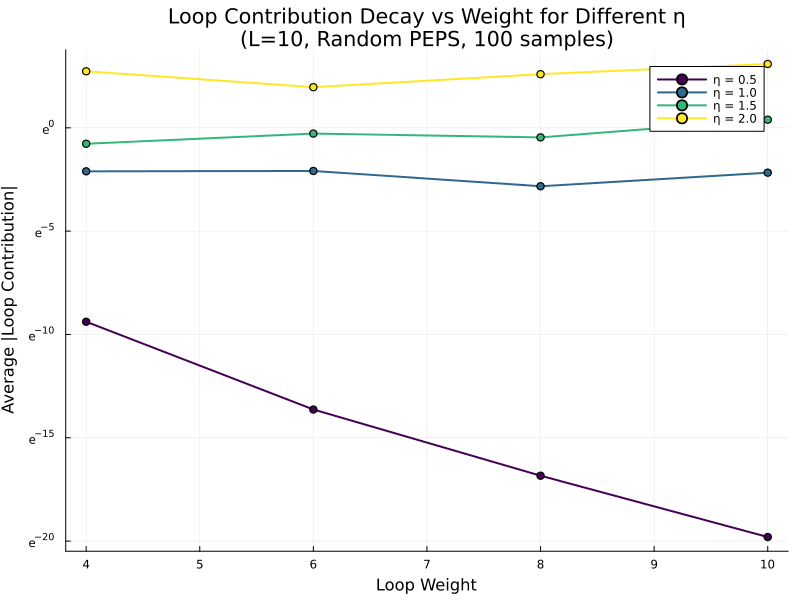

In [124]:
η_arr = 0.5:0.5:2.
nsamples = 100

# Use only the highest weight data which contains all loops up to that weight
all_loops = loop_data[w_list[end]]  # This contains loops of all weights up to 10

# Storage for results across different η values
results_by_eta = Dict()

N = L  # PEPS dimensions
T = L

for η in η_arr
    println("Processing η = $η")
    
    # Storage for this η across all samples
    eta_contributions_by_weight = Dict{Int, Vector{Float64}}()
    for w in w_list
        eta_contributions_by_weight[w] = Float64[]
    end
    
    # Average over multiple samples for each η
    for sample in 1:nsamples
        if sample % 20 == 0
            println("  Sample $sample/$nsamples")
        end
        
        # Get random PEPS tensor network for this η
        tensors, _ = peps_controllable(N, T; η=η, ti=true, orthog=false)
        adj_mat, edges, links = BP.get_adj_mat(tensors)
        messages = BP.get_messages(tensors, edges, links) 
        messages = BP.message_passing(tensors, messages, edges, adj_mat; α=1.0, max_iters=500, diagnose=false, normalise=true)
        Z_list = BP.get_fixed_point_list(tensors, messages, adj_mat)
        tensors = BP.normalize_tensors(tensors, Z_list)
        
        # Calculate loop contributions and organize by actual loop weight (length)
        loop_contributions_by_weight = Dict{Int, Vector{Float64}}()

        for loop in all_loops
            if all([e in edges for e in loop])
                loop_weight = length(loop)  # Actual weight is the loop length
                loop_contri = scalar(BP.loop_contribution(loop, messages, tensors, edges, links, adj_mat))
                
                if !haskey(loop_contributions_by_weight, loop_weight)
                    loop_contributions_by_weight[loop_weight] = Float64[]
                end
                
                push!(loop_contributions_by_weight[loop_weight], abs(loop_contri))  # Take absolute value
            end
        end
        
        # Add sample averages to eta storage
        for w in w_list
            if haskey(loop_contributions_by_weight, w) && !isempty(loop_contributions_by_weight[w])
                push!(eta_contributions_by_weight[w], mean(loop_contributions_by_weight[w]))
            end
        end
    end
    
    # Store averaged results for this η
    results_by_eta[η] = Dict(w => mean(eta_contributions_by_weight[w]) for w in w_list if !isempty(eta_contributions_by_weight[w]))
end

# Create plot with all η values
even_weights = w_list
colors = palette(:viridis, length(η_arr))

p = plot(xlabel="Loop Weight", 
         ylabel="Average |Loop Contribution|",
         title="Loop Contribution Decay vs Weight for Different η\n(L=$L, Random PEPS, $nsamples samples)",
         grid=true,
         legend=:topright,
         size=(800, 600))

for (i, η) in enumerate(η_arr)
    avg_contribs = [results_by_eta[η][w] + 1e-50 for w in even_weights if haskey(results_by_eta[η], w)]
    valid_weights = [w for w in even_weights if haskey(results_by_eta[η], w)]
    
    if !isempty(avg_contribs)
        plot!(p, valid_weights, avg_contribs,
              linewidth=2,
              markershape=:circle,
              yscale=:ln,
              markersize=4,
              label="η = $η",
              color=colors[i])
    end
end

display(p)